In [1]:
%pip install flask


In [ ]:
import os
import pandas as pd
import cv2 as cv
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
from deepface import DeepFace
import logging

# Set up logging
logging.basicConfig(filename='face_recognition.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the path to the ONNX model files
face_detection_model_path = "face_detection_yunet_2023mar.onnx"
face_recognition_model_path = "face_recognition_sface_2021dec.onnx"

# Check if the ONNX model files exist
if not os.path.exists(face_detection_model_path):
    logging.error(f"Face detection model file not found: {face_detection_model_path}")
    raise FileNotFoundError(f"Face detection model file not found: {face_detection_model_path}")

if not os.path.exists(face_recognition_model_path):
    logging.error(f"Face recognition model file not found: {face_recognition_model_path}")
    raise FileNotFoundError(f"Face recognition model file not found: {face_recognition_model_path}")

# Load the face detection and recognition models
detector = cv.FaceDetectorYN.create(
    face_detection_model_path,
    "",
    (320, 320),
    0.7,
    0.3,
    5000,
    backend_id=3
)
recognizer = cv.FaceRecognizerSF.create(
    face_recognition_model_path, "", backend_id=3)

# Set the cosine similarity threshold for face recognition
cosine_similarity_threshold = 0.35

# Define the path to the images directory
path_to_images = "Faces"

# Load the embeddings from the CSV file if it exists and is not empty, otherwise create an empty DataFrame
embeddings_file = "embeddings_df.csv"
if os.path.exists(embeddings_file) and os.path.getsize(embeddings_file) > 0:
    embeddings_df = pd.read_csv(embeddings_file)
    embeddings_df['Embedding'] = embeddings_df['Embedding'].apply(lambda x: np.array([float(t) for t in x.replace('[', '').replace(']', '').split()]))
else:
    embeddings_df = pd.DataFrame(columns=['Name', 'Embedding'])

# Remove any rows with empty or incorrectly formatted embeddings
embeddings_df = embeddings_df[embeddings_df['Embedding'].apply(lambda x: len(x) == 128)]

# Set up Google Sheets credentials
scope = ['https://www.googleapis.com/auth/drive']
json_keyfile_path = r'face-recognition-credentials.json'  # Update with your file path

# Check if the JSON keyfile exists
if not os.path.exists(json_keyfile_path):
    logging.error(f"Google Sheets API credentials file not found: {json_keyfile_path}")
    raise FileNotFoundError(f"Google Sheets API credentials file not found: {json_keyfile_path}")

creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# Specify the Google Sheets document by its URL
sheet_url = "https://docs.google.com/spreadsheets/d/1FvV0U8OOtMRFItP2XbrlHPiFaPoa-xwDTRF4AMVbVGI/edit?gid=0#gid=0"

# Open the Google Sheets document
doc = client.open_by_url(sheet_url)

# Print out the names of all worksheets
worksheets = doc.worksheets()
print("Available worksheets:")
for worksheet in worksheets:
    print(worksheet.title)

# Try to get the worksheet named "Face"
try:
    sheet = doc.worksheet("Face")
    print('Worksheet "Face" found and accessed successfully.')
except gspread.exceptions.WorksheetNotFound:
    print('Worksheet "Face" not found. Creating a new one.')
    sheet = doc.add_worksheet(title="Face", rows="1000", cols="20")
    sheet.append_row(["Identity", "Timestamp", "Emotion"])

# Function to delete processed images from the "Faces" folder
def delete_processed_images():
    for filename in os.listdir(path_to_images):
        image_name = filename[:-4]  # Remove the file extension
        if image_name in embeddings_df['Name'].values:
            os.remove(os.path.join(path_to_images, filename))
            print(f"Deleted processed image: {filename}")

# Function to generate embeddings for known faces
def generate_embeddings():
    global embeddings_df
    for filename in os.listdir(path_to_images):
        if filename.startswith("Unknown_"):
            continue  # Skip processing unknown face images
        img_path = os.path.join(path_to_images, filename)
        img = cv.imread(img_path)
        if img is not None:
            detector.setInputSize([img.shape[1], img.shape[0]])
            face = detector.detect(img)
            if face[1] is not None:
                coords = face[1][0].astype(np.int32)
                if (coords[2] >= 40) and (coords[3] >= 40):
                    face_align = recognizer.alignCrop(img, face[1][0])
                    face_feature = recognizer.feature(face_align)
                    if face_feature.size == 128:  # Check for correct size
                        x = {"Name": filename[:-4], "Embedding": face_feature}
                        if filename[:-4] not in embeddings_df['Name'].values:
                            embeddings_df = pd.concat(
                                [
                                    embeddings_df,
                                    pd.DataFrame.from_dict([x], orient='columns')
                                ],
                                ignore_index=True)
                    else:
                        logging.warning(f"Incorrect feature size for {filename}")
        else:
            print(f"Failed to read image: {img_path}")

# Save the updated embeddings to the CSV file
def save_embeddings():
    embeddings_df.to_csv(embeddings_file, index=False)

# Function to visualize the detected faces, identities, and emotions
def visualize(input, faces, identities=[], emotions=[], thickness=2):
    if faces[1] is not None:
        for idx, face in enumerate(faces[1]):
            coords = face[:-1].astype(np.int32)
            cv.rectangle(input, (coords[0], coords[1]), (coords[0]+coords[2], coords[1]+coords[3]), (0, 255, 0), thickness)
            if identities:
                cv.putText(input, identities[idx], (coords[0], coords[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            if emotions:
                cv.putText(input, emotions[idx], (coords[0], coords[1]+coords[3]+20), cv.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Open the video capture
cap = cv.VideoCapture(0)

new_resolution = 1


fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('rtsp://127.0.0.1:8554/stream', fourcc, 20.0, (640, 480))


last_detection_time = {}
image_count = {}

# Dictionary to track detection statistics
detection_stats = {
    "faces": {},
    "persons": {},
    "moods": {}
}

# Function to determine if an image is blurry
def is_blurry(image, threshold=100.0):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    laplacian_var = cv.Laplacian(gray, cv.CV_64F).var()
    return laplacian_var < threshold

# Function to update detection statistics
def update_detection_stats(identity, emotion, timestamp):
    if identity not in detection_stats["faces"]:
        detection_stats["faces"][identity] = 0
    detection_stats["faces"][identity] += 1

    if emotion not in detection_stats["moods"]:
        detection_stats["moods"][emotion] = 0
    detection_stats["moods"][emotion] += 1

    if timestamp not in detection_stats["persons"]:
        detection_stats["persons"][timestamp] = {"identity": identity, "count": 0}
    detection_stats["persons"][timestamp]["count"] += 1

# Function to get the most detected face, person, and mood
def get_most_detected():
    most_detected_face = max(detection_stats["faces"], key=detection_stats["faces"].get)
    most_detected_mood = max(detection_stats["moods"], key=detection_stats["moods"].get)
    most_detected_time = max(detection_stats["persons"], key=lambda x: detection_stats["persons"][x]["count"])
    most_detected_person = detection_stats["persons"][most_detected_time]["identity"]
    return most_detected_face, most_detected_mood, most_detected_person, most_detected_time

# Main loop for face recognition and emotion detection
def main_loop():
    global embeddings_df
    while True:
        ret, frame = cap.read()
        if ret:
            pic_width = int(frame.shape[1] * new_resolution)
            pic_height = int(frame.shape[0] * new_resolution)
            new_dimension = (pic_width, pic_height)

            frame = cv.resize(frame, new_dimension, interpolation=cv.INTER_AREA)

            detector.setInputSize([frame.shape[1], frame.shape[0]])
            faces = detector.detect(frame)

            identities = []
            emotions = []
            if faces[1] is not None:
                for i in range(len(faces[1])):
                    coords = faces[1][i].astype(np.int32)
                    if faces[1][i][-1] >= 0.7:
                        face1_align = recognizer.alignCrop(frame, faces[1][i])
                        if is_blurry(face1_align):
                            continue  # Skip processing blurry images
                        face1_feature = recognizer.feature(face1_align)
                        identity = ""
                        if face1_feature.size == 128:  # Ensure correct feature size
                            embeddings_df['cosine'] = embeddings_df.Embedding.apply(
                                lambda x: int(recognizer.match(face1_feature, np.reshape(x, face1_feature.shape).astype(np.float32), cv.FaceRecognizerSF_FR_COSINE) > cosine_similarity_threshold))
                            a = embeddings_df[embeddings_df.cosine == 1]
                            if len(a):
                                identity = a.Name.iloc[0].capitalize()
                            else:
                                # Save the unknown face image in the "Faces" folder with limitation
                                timestamp = datetime.now()
                                if "Unknown" not in image_count:
                                    image_count["Unknown"] = 0
                                    last_detection_time["Unknown"] = timestamp
                                if (timestamp - last_detection_time["Unknown"]) < timedelta(minutes=1):
                                    if image_count["Unknown"] < 3:
                                        unknown_filename = f"Unknown_{timestamp.strftime('%Y%m%d_%H%M%S')}.jpg"
                                        unknown_path = os.path.join(path_to_images, unknown_filename)
                                        cv.imwrite(unknown_path, face1_align)
                                        image_count["Unknown"] += 1
                                else:
                                    image_count["Unknown"] = 1
                                    last_detection_time["Unknown"] = timestamp
                                    unknown_filename = f"Unknown_{timestamp.strftime('%Y%m%d_%H%M%S')}.jpg"
                                    unknown_path = os.path.join(path_to_images, unknown_filename)
                                    cv.imwrite(unknown_path, face1_align)
                                identity = "Unknown"
                        else:
                            logging.warning("Empty or incorrect feature vector for detected face.")
                            identity = "Unknown"

                        identities.append(identity)

                        # Detect emotion using DeepFace
                        try:
                            emotion_analysis = DeepFace.analyze(face1_align, actions=['emotion'], enforce_detection=False)
                            if isinstance(emotion_analysis, list):
                                if len(emotion_analysis) > 0 and 'dominant_emotion' in emotion_analysis[0]:
                                    emotion = emotion_analysis[0]['dominant_emotion']
                                else:
                                    emotion = "Unknown"
                            elif isinstance(emotion_analysis, dict) and 'dominant_emotion' in emotion_analysis:
                                emotion = emotion_analysis['dominant_emotion']
                            else:
                                emotion = "Unknown"
                        except Exception as e:
                            logging.error(f"Error in emotion analysis: {e}")
                            emotion = "Unknown"

                        emotions.append(emotion)

                        # Update detection statistics
                        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        update_detection_stats(identity, emotion, timestamp)

                        # Store the detection details in Google Sheets if the time difference is at least 5 seconds
                        current_time = datetime.now()
                        if identity not in last_detection_time or (current_time - last_detection_time[identity]).total_seconds() >= 5:
                            last_detection_time[identity] = current_time
                            row = [identity, timestamp, emotion]
                            try:
                                logging.info(f"Appending row to Google Sheets: {row}")
                                sheet.append_row(row)
                                logging.info("Row appended successfully.")
                            except Exception as e:
                                logging.error(f"Failed to append row to Google Sheets: {e}")

            visualize(frame, faces, identities, emotions)

            cv.imshow('frame', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv.destroyAllWindows()

    # Get and log the most detected face, person, and mood
    most_detected_face, most_detected_mood, most_detected_person, most_detected_time = get_most_detected()
    logging.info(f"Most detected face: {most_detected_face}")
    logging.info(f"Most detected mood: {most_detected_mood}")
    logging.info(f"Most detected person: {most_detected_person} at {most_detected_time}")

    # Print the results to the console
    print(f"Most detected face: {most_detected_face}")
    print(f"Most detected mood: {most_detected_mood}")
    print(f"Most detected person: {most_detected_person} at {most_detected_time}")

if __name__ == "__main__":
    generate_embeddings()
    save_embeddings()
    delete_processed_images()
    main_loop() 


Available worksheets:
Face
Worksheet "Face" found and accessed successfully.
Failed to read image: Faces\.DS_Store


KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_4808\4108607577.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('Time Stamp').resample('H').size().plot()


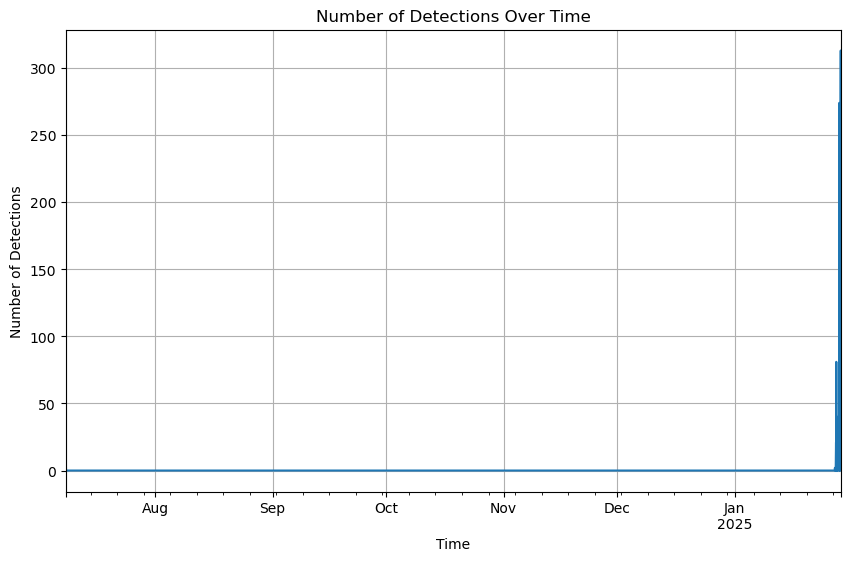

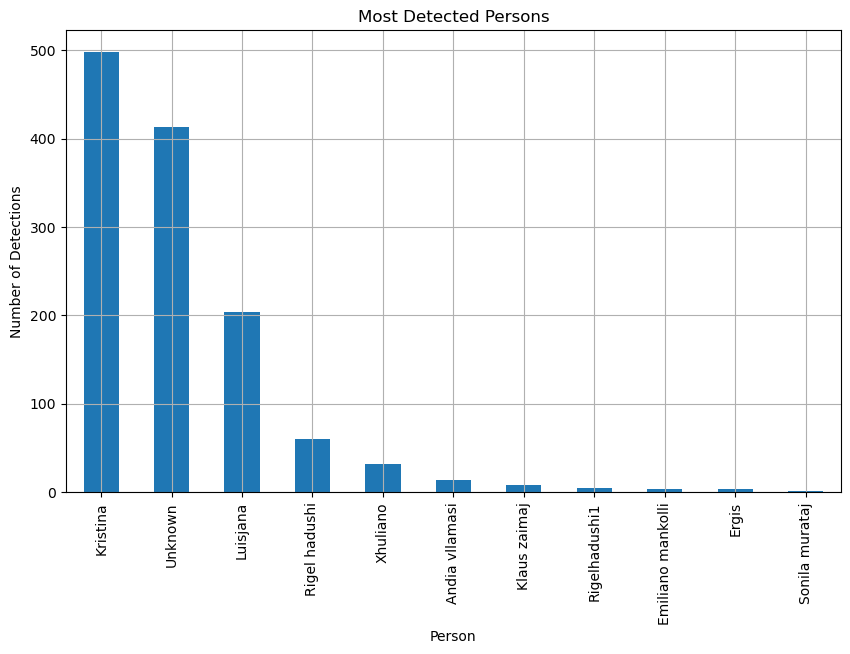

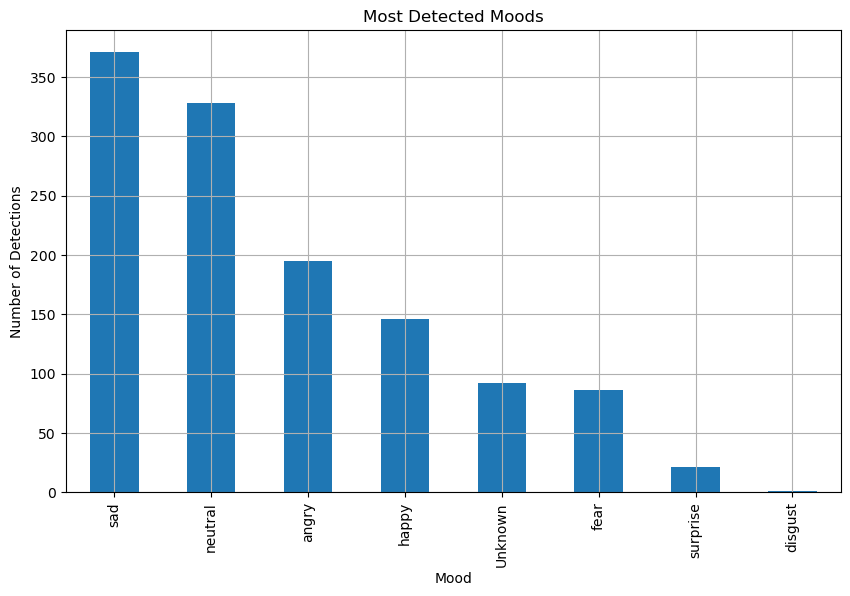

In [1]:
import os

import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import matplotlib.pyplot as plt

# Set up Google Sheets credentials
scope = ['https://www.googleapis.com/auth/drive']
json_keyfile_path = r'face-recognition-credentials.json'  # Update with your file path

# Check if the JSON keyfile exists
if not os.path.exists(json_keyfile_path):
    raise FileNotFoundError(f"Google Sheets API credentials file not found: {json_keyfile_path}")

creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# Specify the Google Sheets document by its URL
sheet_url = "https://docs.google.com/spreadsheets/d/1FvV0U8OOtMRFItP2XbrlHPiFaPoa-xwDTRF4AMVbVGI/edit?gid=0#gid=0"

# Open the Google Sheets document
doc = client.open_by_url(sheet_url)

# Try to get the worksheet named "Face"
try:
    sheet = doc.worksheet("Face")
except gspread.exceptions.WorksheetNotFound:
    raise FileNotFoundError('Worksheet "Face" not found.')

# Load the data from Google Sheets into a pandas DataFrame
data = sheet.get_all_records()
df = pd.DataFrame(data)

# Convert the Timestamp column to datetime
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

# Plot the number of detections over time
plt.figure(figsize=(10, 6))
df.set_index('Time Stamp').resample('H').size().plot()
plt.title('Number of Detections Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()

# Plot the most detected persons
plt.figure(figsize=(10, 6))
df['Identity'].value_counts().plot(kind='bar')
plt.title('Most Detected Persons')
plt.xlabel('Person')
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()

# Plot the most detected moods
plt.figure(figsize=(10, 6))
df['Emotion'].value_counts().plot(kind='bar')
plt.title('Most Detected Moods')
plt.xlabel('Mood')
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()
